# xView3 model

This tutorial is heavily based on the [Pytorch Object Detection Tutorial](https://pytorch.org/tutorials/intermediate/torchvision\_tutorial.html).  As such, it is not intended to represent a *good* approach to the xView3 problem, but rather how a standard approach might be modified to use the xView3 dataset.

## Input Parameters

In [1]:
# Path to training data
data_path = '/data/xview3/data/big/'

# Path to directory containing two directories 'train' and 'validation'  
image_folder = '/data/xview3/data/big/'

# Path to ground truth label files; should contain train.csv and validation.csv
label_file_root = '/data/xview3/data/labels/'

# Path to the label files for close-to-shore data
shore_root='/data/xview3/data/shoreline'

# Path where chips will be written to disk; should be empty to begin with,
chips_path = '/mnt/md127/chips'

# Set true to re-chip dataset, set false to use existing chips
overwrite_preproc = False

# Set cp flag to true to load model, optimizer, and scheduler states from checkpoint, set model to load model nnly, set both false to use new everything
cp_exists, model_exists = False, True

# Define and record paramters:     |batch size|learning rate|momentum|weight decay|# of epochs|
bs, lr, moment, decay, num_epochs =     50,        0.05,       0.8,       0.01,        100

## Imports

In [2]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import pandas as pd
from traceback import format_exc
from pathlib import Path
from engine import train_one_epoch, evaluate
from utils import new_model, xView3BaselineModel, trainer
from utils import read_in_dets, save_checkpoint, record_score, record_params, record_all, format_data, reformat_results
from inference import predict_results
from train import create_datasets
from visualizer import visualizer
from dataloader import generate_loaders_unlabeled, generate_loaders
from metric import score
from constants import PIX_TO_M, FISHING, NONFISHING
from notifier import telegram_notify

## Loading data
xView3 data is made available as a set of GeoTIFFs per Scene ID. Along with [cross (VH) and co (VV) polarization channels](https://earth.esa.int/documents/10174/3166029/Vilnius_radar_general.pdf), we also include [bathymetry](https://www.gebco.net/data_and_products/gridded_bathymetry_data/) and various wind layers.

Since these scenes are very large, the preprocessing code creates ML-ready chips and puts them into easy-to-use [PyTorch datasets](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [3]:
# generate the training and validation subdirectories and move images
train_path, val_path = format_data(Path(data_path))

# Paths defined in accordance with instructions above; should not need to change 
train_data_root = Path(image_folder) / 'train'
train_label_file = Path(label_file_root) / 'train.csv'
train_chips_path = Path(chips_path) / 'train'
val_data_root = Path(image_folder) / 'validation'
val_label_file = Path(label_file_root) / 'validation.csv'
val_chips_path = Path(chips_path) / 'validation'

# Create PyTorch datasets
train_data, val_data = create_datasets(
        train_data_root=train_data_root,
        train_detect_file=train_label_file,
        train_chips_path=train_chips_path,
        val_data_root=val_data_root,
        val_detect_file=val_label_file,
        val_chips_path=val_chips_path,
        overwrite_preproc=overwrite_preproc,
        channels=['vh', 'vv', 'bathymetry'])

531 train IDs and 50 validation IDs


/data/xview3/xview3-reference-main/reference/dataloader.py:583: DtypeWarning: Columns (7,8,11,16) have mixed types.Specify dtype option on import or set low_memory=False.
  process_scene(


Elapsed Time: 1.13 Minutes
Adding background chips...
Number of Unique Chips: 114608
Initialization complete
Elapsed Time: 0.03 Minutes
Number of Unique Chips: 5999
Initialization complete


## Data loaders
Now that our data is loaded and initialized, we want to start setting up the device and DataLoaders to feed the PyTorch model.

Depending on your GPU vRAM, play around with the batch_size for the training and validation data loaders to ensure you don't run into out of memory errors.

In [4]:
# set error handling 
np.seterr(divide='ignore', invalid='ignore')

# train on the GPU or on the CPU, if a GPU is not available
device = trainer()

# define training and validation data loaders
data_loader_train, data_loader_val = generate_loaders(train_data, val_data, bs)

Using device: cuda


## Model (Checkpoint and Restart Point)
The xView3 reference model utilizes the well-known [Faster R-CNN](https://arxiv.org/abs/1506.01497) model that is provided pre-built in the torchvision library. We wrap the Faster R-CNN into a convenience class for ease of use, but the basic structure still remains and should be simple to extend.

The xView3 Faster R-CNN model is instaniated with 3 classes -- `not vessel`, `fishing`, and `not fishing` -- and a pre-defined image mean and standard deviation.  We also -- very naively! -- assume that every detection has a bounding box of the same size.  While validation data for this challenge has bounding boxes, the training data does not.  How you make use of these pieces of information is one of the ways in which you can be creative!

We use a standard stochastic gradient descent optimizer for the Faster R-CNN model. Feel free to play around with more advanced optimizers such as Adam, RMSProp, or others.

Additionally, we use a step-based learning rate scheduler to decay the learning rate over the duration of the training. You could experiment with other LR schedules.  For the reference implementation, we've kept this straightforward.

In [ ]:
# Create everything fresh    
model = new_model(chips_path, overwrite_preproc, train_data)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=moment, weight_decay=decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Load every state from checkpoint
if cp_exists:
    checkpoint = torch.load('weights/best.pth', map_location=device)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    lr_scheduler.load_state_dict(checkpoint['scheduler'])

# Load model state only, use new optimizer and scheduler
elif model_exists:
    model.load_state_dict(torch.load(f'weights/best.pth', map_location=device))

# Move model to the right device
model.to(device)

## Training
Training the model is done via torchvision's provided `train_one_epoch` function which wraps the traditional PyTorch training loop into an easy-to-use function made for built-in object detectors. The model is saved every epoch.

In [ ]:
try:    
    for epoch in range(num_epochs):
        # train for one epoch, printing every iteration
        train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=(115000/(bs*3)))
        
        # update the learning rate
        lr_scheduler.step()
        
        # evaluate on the test dataset
        evaluate(model, data_loader_val, device=device)
        
        # save a model state and full checkpoint object
        save_checkpoint(model, optimizer, lr_scheduler, epoch)
except:
    telegram_notify("Error: " + str(format_exc()))

/data/xview3/anaconda3/envs/xview3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [   0/2293]  eta: 7:23:30  lr: 0.000100  loss: 0.2782 (0.2782)  loss_classifier: 0.0101 (0.0101)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.2461 (0.2461)  loss_rpn_box_reg: 0.0220 (0.0220)  time: 11.6050  data: 9.1184  max mem: 30286
#################################################

## Inference
Let's run inference on the model by re-using one of the validation scenes

In [ ]:
try:
    # Creating a fresh dataloader for evaluation that includes all chips, not just labeled ones
    data_loader_val_unlabeled = generate_loaders_unlabeled(val_data_root, val_data, chips_path) 
    
    # Loading the model and putting it into eval mode on correct device
    model_eval = new_model(chips_path, overwrite_preproc, train_data)
    model_eval.load_state_dict(torch.load(f'trained_model_{num_epochs}_epochs.pth', map_location=device))
    model_eval.to(device)
    model_eval.eval()

    # Running inference - use model state to generate a list of predictions for the unlabeled validation data
    res = predict_results(data_loader_val_unlabeled, model_eval, device)

    # Reformat the results in xView3 format - convert chip-level to scene-level coordinates
    df_out = reformat_results(res, chips_path)
    display(df_out)
except:
    telegram_notify("Error: " + str(format_exc()))

Note that to run inference for the challenge, we must not only run the model forward -- we must also make sure that the output is formatted in the manner expected by the xView3 metric computation code.  The specification for this output can be found in the challenge documentation.

## Metrics
In order to properly detect and classify dark vessel activity in oceans, the xView3 challenge incorporates multiple different factors when scoring how well a model performs for any scene provided for inference. This aggregate metric takes into account five different components, explained below. The functions are implemented in `metric.py`.

$$ M_R = F1_D * \frac{1 + F1_S  + F1_V + F1_F + PE_L}{5} $$

$$ PE_{L} = 1 - \frac{1}{N} \sum_{n=1}^{N} \frac{| \hat{\ell} - \ell|}{\ell}. $$

## Score, Visualize, and Record Results

In [ ]:
try:
    # Score model
    inference, ground_truth = read_in_dets(val_label_file)
    out = score(inference, ground_truth, shore_root, distance_tolerance=200, shore_tolerance=2)
    
    # Copy visuals, parameters, and score to results/resultsDayMonth
    record_params(bs, lr, moment, decay, num_epochs)
    record_score(out)
    record_all(num_epochs)
    
    # Run the visualizer
    visualizer()
    
    # Notify completion
    telegram_notify("Success: " + str(out))
except:
    telegram_notify("Error: " + str(format_exc()))

The telegram group to receive runtime notifications:

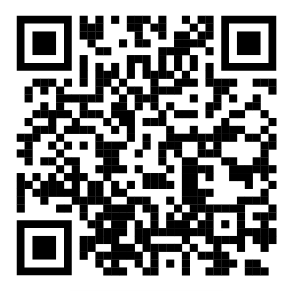